In [13]:
from __future__ import print_function
import pandas as pd
import numpy as np
import keras

from keras import layers,metrics
from keras.optimizers import RMSprop
from keras.layers import Dense, LSTM, Dropout, Activation
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import PReLU, ELU
from keras.models import Sequential, load_model
from keras.utils import np_utils, multi_gpu_model

from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder 
from sklearn.utils import shuffle as reset
from sklearn.model_selection import train_test_split,GridSearchCV,StratifiedShuffleSplit
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import log_loss,make_scorer

from matplotlib.colors import LogNorm
# import 
from matplotlib.pylab import plt
from copy import deepcopy
from datetime import datetime
from imblearn.over_sampling import RandomOverSampler #https://imbalanced-learn.org/stable/generated/imblearn.over_sampling.RandomOverSampler.html?highlight=randomoversampler
from frplayer import FilterResponseNormalization

实验一，完全重现Kaggle第十一名的代码

In [14]:
def train_test_split_DataFrame(data, test_size=0.2, considerTime=True, random_state=None):
    # ConsiderTime-------trainDF和testDF分割时是否考虑时间问题，即是否需要随机打乱。True:按照‘Dates’列进行降序排列,False：随机打乱样本的顺序，
    if considerTime:
        data=data.sort_values(by="Dates", ascending=True)
    else:
        data=reset(data, random_state=random_state)
    train=data[int(len(data)*test_size):].reset_index(drop=True)
    test=data[:int(len(data)*test_size)].reset_index(drop=True)
    return train, test

In [15]:
def parse_time(x):
#     if '-' in x:
#         DD=datetime.strptime(x,"%Y-%m-%d %H:%M:%S")#jjs
#     else:
    DD=datetime.strptime(x,"%Y-%m-%d %H:%M")#zj    
    time=DD.hour#*60+DD.minute
    day=DD.day
    month=DD.month
    year=DD.year
    return time,day,month,year
def Dates2TDMY(x):
    if '-' in x:
        DD=datetime.strptime(x,"%Y-%m-%d %H:%M:%S")#jjs
    else:
        DD=datetime.strptime(x,"%Y/%m/%d %H:%M")#zj  
    time=DD.hour#*60+DD.minute
    day=DD.day
    month=DD.month
    year=DD.year
    #T_D_M_Y=str(time)+str(day)+str(month)+str(year)
    T_D_M_Y=str(time)+str(day)+str(month)
    return T_D_M_Y
def get_season(x):
    summer=0
    fall=0
    winter=0
    spring=0
    if (x in [5, 6, 7]):
        summer=1
    if (x in [8, 9, 10]):
        fall=1
    if (x in [11, 0, 1]):
        winter=1
    if (x in [2, 3, 4]):
        spring=1
    return summer, fall, winter, spring

In [16]:
def field2Vec(trainDF,testDF,fieldStr):
    fields=sorted(trainDF[fieldStr].unique())
    categories=sorted(trainDF["Category"].unique())
    C_counts=trainDF.groupby(["Category"]).size()
    F_C_counts=trainDF.groupby([fieldStr,"Category"]).size()
    F_counts=trainDF.groupby([fieldStr]).size()
    logodds={}
    logoddsPF={}
    MIN_CAT_COUNTS=2
    default_logodds=np.log(C_counts/len(trainDF))-np.log(1.0-C_counts/float(len(trainDF)))
    for f in fields:
        PA=F_counts[f]/float(len(trainDF))
        logoddsPF[f]=np.log(PA)-np.log(1.-PA)
        logodds[f]=deepcopy(default_logodds)
        for cat in F_C_counts[f].keys():
            if (F_C_counts[f][cat]>MIN_CAT_COUNTS) and F_C_counts[f][cat]<F_counts[f]:
                PA=F_C_counts[f][cat]/float(F_counts[f])
                logodds[f][categories.index(cat)]=np.log(PA)-np.log(1.0-PA)
        logodds[f]=pd.Series(logodds[f])
        logodds[f].index=range(len(categories))
    ########此部分代码，从逻辑上不应该出现在此处，但是为了编程的方便，放在了此处#########
    #fieldsTest=sorted(testDF[fieldStr].unique())
    #N_count=0
    #for f in fieldsTest:
        #if f not in fields:
            #logoddsPF[f]=-50.0  #np.log(0.)-np.log(1.)=-inf,便于计算，改为-99999.0
            #logodds[f]=deepcopy(default_logodds)
            #pa=1.0/float(len(categories))
            #logodds[f][range(len(categories))]=np.log(pa)-np.log(1.0-pa)
            #logodds[f]=pd.Series(logodds[f])
            #logodds[f].index=range(len(categories))
            #N_count=N_count+1
    #print(fieldStr+' N_count: '+str(N_count))
    ########此部分代码，从逻辑上不应该出现在此处，但是为了编程的方便，放在了此处#########
    #引进代码原作者的新思想
    if testDF.shape[0]>0: #如果testDF里有样本,......
        new_fields=sorted(testDF[fieldStr].unique())
        new_F_counts=testDF.groupby(fieldStr).size()
        only_new=set(new_fields+fields)-set(fields)
        only_old=set(new_fields+fields)-set(new_fields)
        in_both=set(new_fields).intersection(fields)
        print('# only_new_fieldds:'+str(len(only_new)))
        for f in only_new:
            PA=new_F_counts[f]/float(len(testDF)+len(trainDF))
            logoddsPF[f]=np.log(PA)-np.log(1.-PA)
            logodds[f]=deepcopy(default_logodds)
            logodds[f].index=range(len(categories))
        for f in in_both:
            PA=(F_counts[f]+new_F_counts[f])/float(len(testDF)+len(trainDF))
            logoddsPF[f]=np.log(PA)-np.log(1.-PA)    
    return logodds,logoddsPF

In [17]:
def parse_data(df,logodds_A,logoddsPF_A,logodds_T,logoddsPF_T,needT_D_M_Y=False):
    feature_list=df.columns.tolist()
    if "Descript" in feature_list:
        feature_list.remove("Descript")
    if "Resolution" in feature_list:
        feature_list.remove("Resolution")
    if "Category" in feature_list:
        feature_list.remove("Category")
    if "Id" in feature_list:
        feature_list.remove("Id")

    cleanData=df[feature_list]
    cleanData.index=range(len(df))
    print("Creating address features")###Creating address features###
    address_features=cleanData["Address"].apply(lambda x: logodds_A[x])
    address_features.columns=["logodds_A"+str(x) for x in range(len(address_features.columns))]
    if needT_D_M_Y:
        print("Creating time T_D_M_Y features")###Creating time T_D_M_Y features###
        T_D_M_Y_features=cleanData["T_D_M_Y"].apply(lambda xx: logodds_T[xx])
        T_D_M_Y_features.columns=["logodds_T"+str(xx) for xx in range(len(T_D_M_Y_features.columns))]

    print("Parsing dates")            ###Creating address features###
    cleanData["Time"], cleanData["Day"], cleanData["Month"], cleanData["Year"]=zip(*cleanData["Dates"].apply(parse_time))
    #     dummy_ranks_DAY = pd.get_dummies(cleanData['DayOfWeek'], prefix='DAY')
    days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    #     cleanData["DayOfWeek"]=cleanData["DayOfWeek"].apply(lambda x: days.index(x)/float(len(days)))
    print("Creating one-hot variables")
    dummy_ranks_PD = pd.get_dummies(cleanData['PdDistrict'], prefix='PD')
    dummy_ranks_DAY = pd.get_dummies(cleanData["DayOfWeek"], prefix='DAY')
    cleanData["IsInterection"]=cleanData["Address"].apply(lambda x: 1 if "/" in x else 0)
    cleanData["logoddsPF_A"]=cleanData["Address"].apply(lambda x: logoddsPF_A[x])
    if needT_D_M_Y:
        cleanData["logoddsPF_T"]=cleanData["T_D_M_Y"].apply(lambda x: logoddsPF_T[x])
    print("droping processed columns")
    cleanData=cleanData.drop("PdDistrict",axis=1)
    cleanData=cleanData.drop("DayOfWeek",axis=1)
    cleanData=cleanData.drop("Address",axis=1)    
    cleanData=cleanData.drop("Dates",axis=1)
    if needT_D_M_Y:
        cleanData=cleanData.drop("T_D_M_Y",axis=1)
    feature_list=cleanData.columns.tolist()
    print("joining one-hot features")
    if needT_D_M_Y:
        features = cleanData[feature_list].join(dummy_ranks_PD.iloc[:,:]).join(dummy_ranks_DAY.iloc[:,:]).join(address_features.iloc[:,:]).join(T_D_M_Y_features.iloc[:,:])
    else:
        features = cleanData[feature_list].join(dummy_ranks_PD.iloc[:,:]).join(dummy_ranks_DAY.iloc[:,:]).join(address_features.iloc[:,:])
    print("creating new features")
    features["IsDup"]=pd.Series(features.duplicated()|features.duplicated(keep='last')).apply(int)
    features["Awake"]=features["Time"].apply(lambda x: 1 if (x==0 or (x>=8 and x<=23)) else 0)
    features["Summer"], features["Fall"], features["Winter"], features["Spring"]=zip(*features["Month"].apply(get_season))
    if "Category" in df.columns:
        labels = df["Category"].astype('category')
    else:
        labels=None
    return features,labels

In [18]:
def generator(X, Y, lookback, delay, min_index, max_index, shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(X) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows), lookback // step, X.shape[-1]))
        targets = np.zeros((len(rows),Y.shape[1]))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = X[indices]
            targets[j] = Y[rows[j]+delay]
        yield samples, targets
    #Now here is the data generator that we will use. It yields a tuple (samples, targets) where samples is one batch of input data and targets is the corresponding array of target temperatures. It takes the following arguments:
        # •data: The original array of floating point data, which we just normalized in the code snippet above.
        # •lookback: How many timesteps back should our input data go.
        # •delay: How many timesteps in the future should our target be.
        # •min_index and max_index: Indices in the data array that delimit which timesteps to draw from. This is useful for keeping a segment of the data for validation and another one for testing.
        # •shuffle: Whether to shuffle our samples or draw them in chronological order.
        # •batch_size: The number of samples per batch.
        # •step: The period, in timesteps, at which we sample data. We will set it 6 in order to draw one data point every hour.

In [19]:
#Import data
ConsiderTime=False# True##trainDF和testDF分割时是否考虑时间问题，即是否需要随机打乱。True:按照‘Dates’列进行降序排列,False：随机打乱样本的顺序，
Rate_ALL=0.0 #0.0即不保留测试机
needOverSampler=False
needT_D_M_Y=False
allDF=pd.read_csv("./HuZhou.csv")
print('The shape of OrginalAllDF: '+str(allDF.shape))

xy_scaler=preprocessing.StandardScaler()
xy_scaler.fit(allDF[["X","Y"]])
allDF[["X","Y"]]=xy_scaler.transform(allDF[["X","Y"]])
print('The shape of AllDF before del wrong X and Y values: '+str(allDF.shape))
allDF=allDF[abs(allDF["Y"])<100]
allDF.index=range(len(allDF))
print('The shape of AllDF after del wrong X and Y values: '+str(allDF.shape))

def listCat(x):
    return list(x)
allDF.drop_duplicates(inplace=True,subset=['Dates', 'DayOfWeek', 'PdDistrict', 'Address', 'X', 'Y', 'Category'])
Train_duplicated=pd.pivot_table(allDF,index=['Dates','DayOfWeek','PdDistrict', 'Address', 'X', 'Y'], values='Category',aggfunc=[len,listCat])
print('The shape of AllDF after drop_duplicates: '+str(allDF.shape))
print(Train_duplicated.shape)

trainDF,testDF=train_test_split_DataFrame(allDF, test_size=Rate_ALL, considerTime=ConsiderTime, random_state=None)
print('Address_counts_allDF_trainDF_testDF: ' + str(len(allDF["Address"].unique())) + '_'+ str(len(trainDF["Address"].unique())) + '_' + str(len(testDF["Address"].unique())))

N_AllSample=allDF.shape[0]
N_AllTrain=trainDF.shape[0]
N_AllTest=testDF.shape[0]
N_CLASS=len(allDF["Category"].unique())
print('The # of AllDF, AllTrain, AllTest, is: '+str(N_AllSample)+','+str(N_AllTrain)+','+str(N_AllTest))
#################Now proceed as before#################
print('-----------LOGOODS: Address-------------')
logodds_A,logoddsPF_A=field2Vec(trainDF,testDF,"Address")
if needT_D_M_Y:
    trainDF["T_D_M_Y"]=trainDF["Dates"].apply(Dates2TDMY)
    trainDF["T_D_M_Y"]=trainDF["T_D_M_Y"]+trainDF["DayOfWeek"]
    if Rate_ALL>0:
        testDF[["X","Y"]]=xy_scaler.transform(testDF[["X","Y"]])
        testDF["T_D_M_Y"]=testDF["Dates"].apply(Dates2TDMY)
        testDF["T_D_M_Y"]=testDF["T_D_M_Y"]+testDF["DayOfWeek"]
    print('-----------LOGOODS: T_D_M_Y-------------')
    logodds_T,logoddsPF_T=field2Vec(trainDF,testDF,"T_D_M_Y")    
else:
    logodds_T=None
    logoddsPF_T=None
    
print('-----------LOGOODS: parse_data of Alltrain  -------------')
features, labels=parse_data(trainDF,logodds_A,logoddsPF_A,logodds_T,logoddsPF_T,needT_D_M_Y) 
if Rate_ALL>0:
    print('-----------LOGOODS: parse_data of Alltest  -------------')
    features_test, labels_test=parse_data(testDF,logodds_A,logoddsPF_A,logodds_T,logoddsPF_T,needT_D_M_Y)###########和训练集使用同样的时间和地点Logoodds值#####
    x_test=features_test.values
    y_test=labels_test.values
    y_test = keras.utils.to_categorical(LabelEncoder().fit_transform(np.array(y_test)), num_classes=N_CLASS)

print(features.columns.tolist())
print(len(features.columns))

collist=features.columns.tolist()
scaler = preprocessing.StandardScaler()
scaler.fit(features)
features[collist]=scaler.transform(features)
if Rate_ALL>0:
    features_test[collist]=scaler.transform(features_test)###########和训练集使用同样的scaler值#####
######################################################
#############################先进行过采样，然后再根据时间来排序##################################
if needOverSampler:
    print('------------RandomOverSampler--------------')
    ros = RandomOverSampler()
    featuresArrayOverSampler, labelsArrayOverSampler = ros.fit_resample(features.values,labels.values)#####过采样#####
    N_AllTrain_OverSampler=int(featuresArrayOverSampler.shape[0])
    print('Shape of OverSampler of AllTrain: '+str(featuresArrayOverSampler.shape))
else:
    featuresArrayOverSampler=features.values
    labelsArrayOverSampler=labels.values
    N_AllTrain_OverSampler=int(featuresArrayOverSampler.shape[0])
    print('------------Attention: we do not RandomOverSampler---------------')
if ConsiderTime:
    #####按照年（第6列）月（第5列）日（第4列）时（第3列）排序
    print('------------Sort--------------')
    time_temp=featuresArrayOverSampler[:,2]+np.dot(featuresArrayOverSampler[:,3],100)+np.dot(featuresArrayOverSampler[:,4],10000)+np.dot(featuresArrayOverSampler[:,5],1000000)
    features_label_time=np.column_stack((featuresArrayOverSampler,labelsArrayOverSampler))
    features_label_time=np.column_stack((features_label_time,time_temp))
    features_label_time =features_label_time[np.argsort(features_label_time[:,-1])]
    labelsArrayOverSampler=features_label_time[:,-2]
    featuresArrayOverSampler=features_label_time[:,0:featuresArrayOverSampler.shape[1]]
    del features_label_time
    #############################先进行过采样，然后再根据时间来排序----结束############################

The shape of OrginalAllDF: (145962, 9)
The shape of AllDF before del wrong X and Y values: (145962, 9)
The shape of AllDF after del wrong X and Y values: (145960, 9)
The shape of AllDF after drop_duplicates: (145876, 9)
(145859, 2)
Address_counts_allDF_trainDF_testDF: 17161_17161_0
The # of AllDF, AllTrain, AllTest, is: 145876,145876,0
-----------LOGOODS: Address-------------
-----------LOGOODS: parse_data of Alltrain  -------------
Creating address features
Parsing dates


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Creating one-hot variables
droping processed columns
joining one-hot features
creating new features
['X', 'Y', 'Time', 'Day', 'Month', 'Year', 'IsInterection', 'logoddsPF_A', 'PD_星期一', 'PD_星期三', 'PD_星期二', 'PD_星期五', 'PD_星期六', 'PD_星期四', 'PD_星期日', 'DAY_星期一', 'DAY_星期三', 'DAY_星期二', 'DAY_星期五', 'DAY_星期六', 'DAY_星期四', 'DAY_星期日', 'logodds_A0', 'logodds_A1', 'logodds_A2', 'logodds_A3', 'logodds_A4', 'logodds_A5', 'logodds_A6', 'logodds_A7', 'logodds_A8', 'logodds_A9', 'logodds_A10', 'logodds_A11', 'logodds_A12', 'logodds_A13', 'logodds_A14', 'logodds_A15', 'logodds_A16', 'logodds_A17', 'logodds_A18', 'logodds_A19', 'logodds_A20', 'logodds_A21', 'logodds_A22', 'logodds_A23', 'logodds_A24', 'logodds_A25', 'logodds_A26', 'logodds_A27', 'logodds_A28', 'logodds_A29', 'logodds_A30', 'logodds_A31', 'logodds_A32', 'logodds_A33', 'logodds_A34', 'logodds_A35', 'logodds_A36', 'logodds_A37', 'logodds_A38', 'logodds_A39', 'logodds_A40', 'logodds_A41', 'logodds_A42', 'logodds_A43', 'logodds_A44', 'logodds_A45'

In [20]:
if Rate_ALL>0:
    print('------------RandomOverSampler for AllTest--------------')
    ros = RandomOverSampler()
    featuresArray_test, labelsArray_test = ros.fit_resample(features_test.values,labels_test.values)#####过采样#####
    N_AllTest_OverSampler=int(featuresArray_test.shape[0])
    labelsArray_test = keras.utils.to_categorical(LabelEncoder().fit_transform(np.array(labelsArray_test)), num_classes=N_CLASS)
    print('Shape of OverSampler of AllTest: '+str(featuresArray_test.shape))

In [21]:
####TEST DNN
print('------------Building DNN model--------------')
ShuffleInTraining=True
N_EPOCHS=50
N_HN_1=128
N_HN=128
N_LAYERS=1
N_BATCH=64
dp=0.5
Rate_Val=0.5
N_Val_OverSampler=int(np.around(N_AllTrain_OverSampler*Rate_Val))
N_Train_OverSampler=int(N_AllTrain_OverSampler-N_Val_OverSampler)
N_CLASS=len(allDF["Category"].unique())
input_dim=featuresArrayOverSampler.shape[1]
output_dim=N_CLASS

model = Sequential()
model.add(Dense(N_HN_1,input_dim=input_dim))
model.add(PReLU())
model.add(Dropout(dp))
for i in range(N_LAYERS):
    model.add(Dense(N_HN))
    model.add(PReLU())
    model.add(BatchNormalization())   
    model.add(Dropout(dp))
model.add(Dense(output_dim))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy', metrics.top_k_categorical_accuracy])

x_train,x_val,y_train,y_val = train_test_split(featuresArrayOverSampler,labelsArrayOverSampler,test_size=N_Val_OverSampler,train_size=N_Train_OverSampler, shuffle=True)
# ros_train = RandomOverSampler()
# x_train, y_train = ros_train.fit_resample(x_train,y_train)#####过采样#####
# ros_val = RandomOverSampler()
# x_val, y_val = ros_val.fit_resample(x_val,y_val)#####过采样#####


y_train = keras.utils.to_categorical(LabelEncoder().fit_transform(np.array(y_train)), num_classes=N_CLASS)
y_val = keras.utils.to_categorical(LabelEncoder().fit_transform(np.array(y_val)), num_classes=N_CLASS)
print('------------DNN Training Go! Go! Go!!!!-----------')
# fitting=model.fit(x_train, y_train, epochs=N_EPOCHS, batch_size=N_BATCH,verbose=2,validation_data=(x_val,y_val),shuffle=True)
fitting=model.fit(x_train, y_train, epochs=N_EPOCHS, batch_size=N_BATCH,verbose=2,validation_data=(x_val,y_val),shuffle=True)

# acc_test, test_score,fitting, model = build_and_fit_model(features_train.values,labels_train,x_val=features_test.values,y_test=labels_test,hn=N_HN,layers=N_LAYERS,epochs=N_EPOCHS,verbose=2,dp=DP)
model.save('jjs_model_0306V1.h5')

------------Building DNN model--------------
------------DNN Training Go! Go! Go!!!!-----------
Train on 72938 samples, validate on 72938 samples
Epoch 1/50
 - 13s - loss: 2.1649 - accuracy: 0.4869 - top_k_categorical_accuracy: 0.7842 - val_loss: 1.5570 - val_accuracy: 0.5629 - val_top_k_categorical_accuracy: 0.8946
Epoch 2/50
 - 12s - loss: 1.6356 - accuracy: 0.5532 - top_k_categorical_accuracy: 0.8831 - val_loss: 1.5278 - val_accuracy: 0.5665 - val_top_k_categorical_accuracy: 0.8959
Epoch 3/50
 - 12s - loss: 1.5943 - accuracy: 0.5577 - top_k_categorical_accuracy: 0.8884 - val_loss: 1.5215 - val_accuracy: 0.5665 - val_top_k_categorical_accuracy: 0.8974
Epoch 4/50
 - 12s - loss: 1.5753 - accuracy: 0.5594 - top_k_categorical_accuracy: 0.8900 - val_loss: 1.5110 - val_accuracy: 0.5685 - val_top_k_categorical_accuracy: 0.8991
Epoch 5/50
 - 15s - loss: 1.5634 - accuracy: 0.5621 - top_k_categorical_accuracy: 0.8924 - val_loss: 1.5065 - val_accuracy: 0.5689 - val_top_k_categorical_accuracy: 0

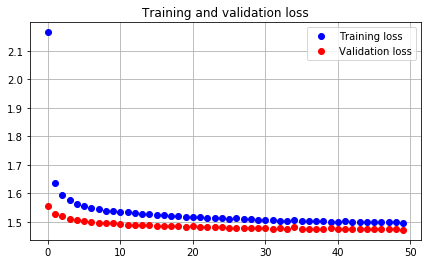

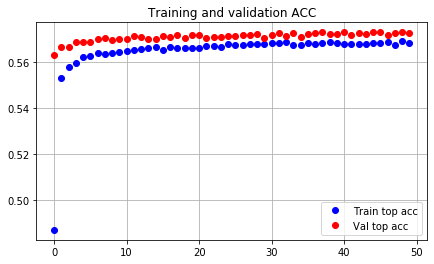

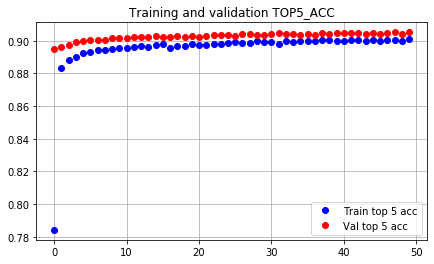

In [22]:
loss = fitting.history['loss']
val_loss = fitting.history['val_loss']
epochs = range(len(loss))
plt.figure(figsize=(7,4))
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'ro', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.grid() 
plt.savefig('./Batc64HN128_64_Ep30_LOSS.png')
plt.show()

top_acc_train=fitting.history['accuracy']
top_acc=fitting.history['val_accuracy']
epochs = range(len(loss))
plt.figure(figsize=(7,4))
plt.plot(epochs, top_acc_train, 'bo', label='Train top acc')
plt.plot(epochs, top_acc, 'ro', label='Val top acc')
plt.title('Training and validation ACC')
plt.legend()
plt.grid() 
plt.savefig('./Batc64HN128_64_Ep30_ACC.png')
plt.show()

top5_acc_train=fitting.history['top_k_categorical_accuracy']
top5_acc=fitting.history['val_top_k_categorical_accuracy']
epochs = range(len(loss))
plt.figure(figsize=(7,4))
plt.plot(epochs, top5_acc_train, 'bo', label='Train top 5 acc')
plt.plot(epochs, top5_acc, 'ro', label='Val top 5 acc')
plt.title('Training and validation TOP5_ACC')
plt.legend()
plt.grid() 
plt.savefig('./Batc64HN128_64_Ep30_TOP5ACC.png')
plt.show()

In [40]:
import tensorflow as tf
from keras import backend as K
 
K.clear_session()
tf.reset_default_graph()